## Import Necessary Library

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

## Load Dataset

In [2]:
df = pd.read_csv('dataset/car_price.csv')

In [3]:
df.head()

,name,company,year,Price,kms_driven,fuel_type
0,Hyundai Santro Xing XO eRLX Euro III,Hyundai,2007,"80,000","45,000 kms",Petrol
1,Mahindra Jeep CL550 MDI,Mahindra,2006,"4,25,000",40 kms,Diesel
2,Maruti Suzuki Alto 800 Vxi,Maruti,2018,Ask For Price,"22,000 kms",Petrol
3,Hyundai Grand i10 Magna 1.2 Kappa VTVT,Hyundai,2014,"3,25,000","28,000 kms",Petrol
4,Ford EcoSport Titanium 1.5L TDCi,Ford,2014,"5,75,000","36,000 kms",Diesel


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        892 non-null    object
 1   company     892 non-null    object
 2   year        892 non-null    object
 3   Price       892 non-null    object
 4   kms_driven  840 non-null    object
 5   fuel_type   837 non-null    object
dtypes: object(6)
memory usage: 41.9+ KB


## Create Backup For Dataset

In [5]:
backup = df.copy()

## Clean "year" Field Data

In [6]:
df = df[df['year'].str.isnumeric()]

In [7]:
df['year'] = pd.to_numeric(df['year'])

## Clean "price" Field Data

In [9]:
df = df[df['Price'] != 'Ask For Price']

In [10]:
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))

## Clean "kms_driven" Field Data

In [11]:
df['kms_driven'] = df['kms_driven'].str.split().str.get(0).str.replace(',', '')

In [12]:
df = df[df['kms_driven'].str.isnumeric()]

In [13]:
df['kms_driven'] = pd.to_numeric(df['kms_driven'])

## Clean "fuel_type" Field Data

In [18]:
df = df[~df['fuel_type'].isnull()]

## Slice "name" Field To 3 Words 

In [26]:
df['name'] = df['name'].str.split().str.slice(0, 3).str.join(' ')

## Check For Outliers

In [32]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,816.0,2012.444853,4.002992,1995.0,2010.0,2013.0,2015.0,2019.0
Price,816.0,411717.615196,475184.422264,30000.0,175000.0,299999.0,491250.0,8500003.0
kms_driven,816.0,46275.531863,34297.428044,0.0,27000.0,41000.0,56818.5,400000.0


<AxesSubplot:xlabel='Price'>

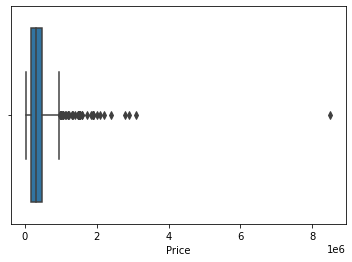

In [28]:
sns.boxplot(x='Price', data=df)

<AxesSubplot:xlabel='kms_driven'>

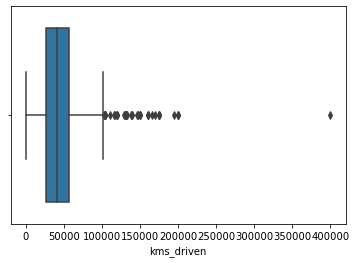

In [30]:
sns.boxplot(x='kms_driven', data=df)

## Exclude Outliers Data

In [34]:
df = df[df['Price'] < 6e6]

In [41]:
df = df[df['kms_driven'] < 300000]

## Reset Data Frame Index

In [43]:
df = df.reset_index(drop=True)

## Split Dataset Into Training And Testing Data

In [46]:
X = df.drop('Price', axis=1)
y = df['Price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## Apply One Hot Encoder To Object Type Fields

In [49]:
ohe = OneHotEncoder()
ohe.fit(X[['name', 'company', 'fuel_type']])

OneHotEncoder()

In [51]:
column_trans = make_column_transformer(
    (
        OneHotEncoder(categories=ohe.categories_),
        ['name', 'company', 'fuel_type']
    ),
    remainder='passthrough'
)

## Create Linear Regression Model

In [52]:
model = LinearRegression()

In [53]:
pipe = make_pipeline(column_trans, model)

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Audi A3 Cabriolet', 'Audi A4 1.8', 'Audi A4 2.0', 'Audi A6 2.0',
       'Audi A8', 'Audi Q3 2.0', 'Audi Q5 2.0', 'Audi Q7', 'BMW 3 Series',
       'BMW 5 Series', 'BMW 7 Series', 'BMW X1', 'BMW X1 sDrive20d',
       'BMW X1 xDrive20d', 'Chevrolet Beat', 'Chevrolet Beat...
                                                                            array(['Audi', 'BMW', 'Chevrolet', 'Datsun', 'Fiat', 'Force', 'Ford',
       'Hindustan', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Land',
       'Mahindra', 'Maruti', 'Mercedes', 'Mini', 'Mitsubishi', 'Nissan',
       'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype=object),
                                                                            array(['Diesel', 'LPG', 'Petrol'], dtype=object)]),
                                                  ['name', 'company',
                                                   'fuel_type'])])),
                ('linearregression', LinearRegression())])

In [55]:
y_predict = pipe.predict(X_test)

In [56]:
r2_score(y_test, y_predict)

0.658349908356938

## Improve Model Performance By Deciding Random State When Splitting Dataset

In [58]:
scores = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=i)
    model = LinearRegression()
    pipe = make_pipeline(column_trans, model)
    pipe.fit(X_train, y_train)
    y_predict = pipe.predict(X_test)
    scores.append(r2_score(y_test, y_predict))

In [61]:
optimal_random_state = np.argmax(scores)

In [62]:
scores[optimal_random_state]

0.9038169185099911

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=optimal_random_state)
model = LinearRegression()
pipe = make_pipeline(column_trans, model)
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
r2_score(y_test, y_predict)

0.9038169185099911

## Test Predict Car

In [68]:
pipe.predict(pd.DataFrame([['Maruti Suzuki Swift', 'Maruti', 2015, 10000, 'Petrol']], columns=['name', 'company', 'year', 'kms_driven', 'fuel_type']))

array([335333.36430919])

## Generate File That Should Be Used On Project Development Using Flask

In [69]:
pickle.dump(pipe, open('CarPricePredictorModel.pkl', 'wb'))

In [70]:
df.to_csv('cleaned_car_price.csv')